In [1]:
import pandas as pd

df = pd.read_csv('ratings.csv')
df=df.drop(columns='timestamp')
df.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# Regularized Singular Value Decomposition

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds

# Assuming your dataset is in a Pandas DataFrame df with columns 'userId', 'movieId', 'rating'

# Create a user-item matrix
user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Fill missing values and convert to a NumPy array
user_item_matrix_array = user_item_matrix.fillna(0).values

# Perform Singular Value Decomposition (SVD) with regularization
def svd_with_regularization(matrix, k=50, lambda_reg=0.01):
    U, sigma, Vt = svds(matrix, k=k)

    # Regularize the diagonal matrix
    sigma_diag = np.diag(sigma + lambda_reg)

    # Reconstruct the user-item matrix with regularization
    predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt)

    return predicted_ratings

# Specify regularization strength (lambda)
lambda_reg = 0.01

# Perform SVD with regularization
predicted_ratings = svd_with_regularization(user_item_matrix_array, k=50, lambda_reg=lambda_reg)

# Function to get recommendations for a given user
def get_top_n_recommendations_svd(user_id, predicted_ratings, user_item_matrix, n=10):
    user_ratings = predicted_ratings[user_id - 1]
    
    # Exclude items the target user has already rated
    user_ratings[user_item_matrix.iloc[user_id - 1] > 0] = 0
    
    # Get indices of top N recommendations
    top_n_indices = user_ratings.argsort()[::-1][:n]
    
    return top_n_indices

# Specify hyperparameters
k_svd = 50  # Number of latent factors
lambda_reg_svd = 0.01  # Regularization parameter
n_recommendations_svd = 5  # Number of recommendations
# Example: Get top 5 recommendations for user with userId=1 using Regularized SVD
user_id_to_recommend = 1
top_recommendations_svd = get_top_n_recommendations_svd(user_id_to_recommend, predicted_ratings, user_item_matrix, n=5)
print(f"Top 5 recommendations for user {user_id_to_recommend} using Regularized SVD: {top_recommendations_svd}")


Top 5 recommendations for user 1 using Regularized SVD: [ 793  921 1066 1444  659]


# Evaluation of the system

Mean Squared Error (MSE): 3.9906144812360043
Root Mean Squared Error (RMSE): 1.9976522423174672


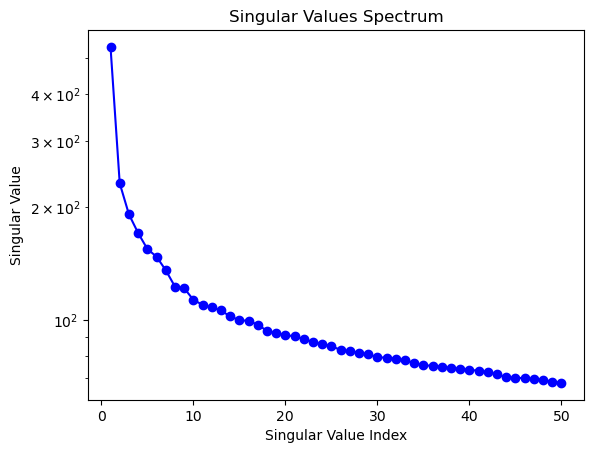

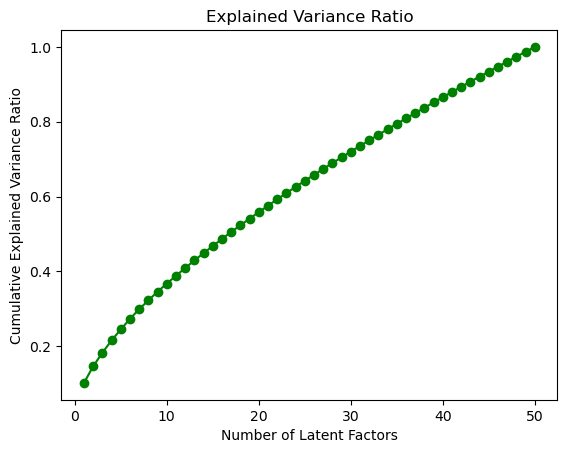

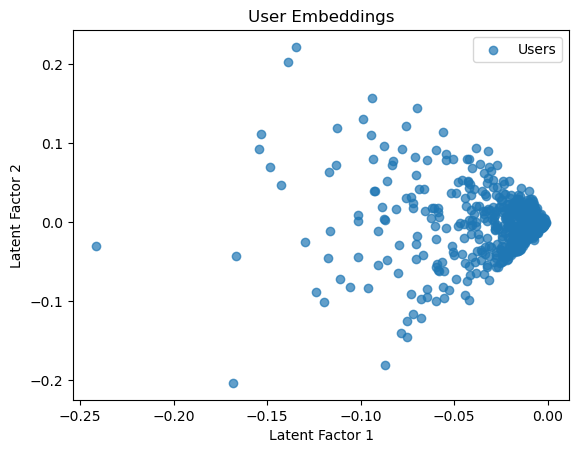

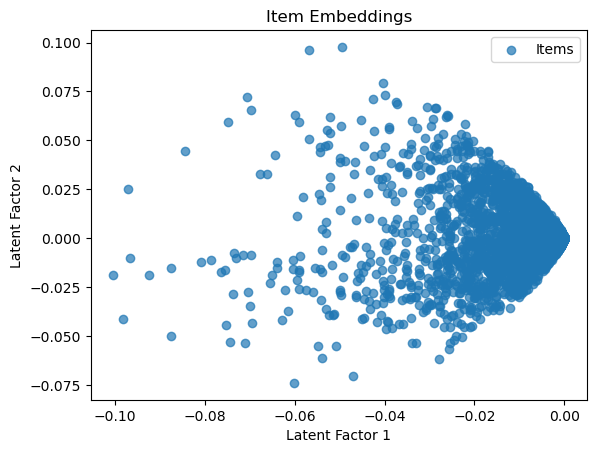

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import seaborn as sns
import matplotlib.pyplot as plt

user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

k_svd = 50  # Number of latent factors
lambda_reg_svd = 0.01  # Regularization parameter

# Function to perform Singular Value Decomposition (SVD) with regularization
def svd_with_regularization(matrix, k=50, lambda_reg=0.01):
    U, sigma, Vt = svds(matrix, k=k)

    # Regularize the diagonal matrix
    sigma_diag = np.diag(sigma + lambda_reg)

    # Reconstruct the user-item matrix with regularization
    predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt)

    return predicted_ratings

# Function to evaluate the recommender system using MSE and RMSE
def evaluate_recommender_system(actual_ratings, predicted_ratings):
    actual_ratings_flattened = actual_ratings[actual_ratings.nonzero()].flatten()
    predicted_ratings_flattened = predicted_ratings[actual_ratings.nonzero()].flatten()

    mse = mean_squared_error(actual_ratings_flattened, predicted_ratings_flattened)
    rmse = np.sqrt(mse)

    return mse, rmse

# Perform SVD with regularization
predicted_ratings_svd = svd_with_regularization(user_item_matrix.values, k=k_svd, lambda_reg=lambda_reg_svd)

# Evaluate the recommender system
mse, rmse = evaluate_recommender_system(user_item_matrix.values, predicted_ratings_svd)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Visualizations

# Singular Values Spectrum
U, sigma, Vt = svds(user_item_matrix.values, k=k_svd)
plt.plot(np.arange(1, k_svd + 1), sigma[::-1], marker='o', linestyle='-', color='b')
plt.title('Singular Values Spectrum')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.yscale('log')
plt.show()

# Explained Variance Ratio
explained_variance_ratio = np.cumsum(sigma[::-1]) / np.sum(sigma)
plt.plot(np.arange(1, k_svd + 1), explained_variance_ratio, marker='o', linestyle='-', color='g')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

# Scatter plot of user embeddings
U, sigma, Vt = svds(user_item_matrix.values, k=2)
user_embeddings = U[:, ::-1]
plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1], label='Users', alpha=0.7)
plt.title('User Embeddings')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.legend()
plt.show()

# Scatter plot of item embeddings
item_embeddings = Vt.T[:, ::-1]
plt.scatter(item_embeddings[:, 0], item_embeddings[:, 1], label='Items', alpha=0.7)
plt.title('Item Embeddings')
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.legend()
plt.show()


This code performs the following:

Evaluates the recommender system using MSE and RMSE.
Plots the singular values spectrum to understand the importance of each latent factor.
Plots the explained variance ratio to understand how much variance is captured by the selected latent factors.
Creates scatter plots of user and item embeddings for a visual representation of their distribution in the latent space.
You can customize these visualizations based on your preferences and the specifics of your dataset.

# Cross Validation

In [4]:
from sklearn.model_selection import KFold

# Specify the number of folds for cross-validation
num_folds = 5

# Function to perform cross-validated evaluation
def cross_validate_recommender_system(data, k=50, lambda_reg=0.01, num_folds=5):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    mse_values = []
    rmse_values = []

    for train_index, test_index in kf.split(data):
        # Split the data into training and testing sets
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Create user-item matrices for training and testing
        train_user_item_matrix = train_data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
        test_user_item_matrix = test_data.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

        # Perform SVD with regularization on the training data
        predicted_ratings = svd_with_regularization(train_user_item_matrix.values, k=k, lambda_reg=lambda_reg)

        # Evaluate the model on the test data
        mse, rmse = evaluate_recommender_system(test_user_item_matrix.values, predicted_ratings)
        mse_values.append(mse)
        rmse_values.append(rmse)

    return mse_values, rmse_values

# Perform cross-validated evaluation
cross_val_mse, cross_val_rmse = cross_validate_recommender_system(df, k=k_svd, lambda_reg=lambda_reg_svd, num_folds=num_folds)

# Print the cross-validated results
print(f'Cross-validated Mean Squared Error (MSE): {np.mean(cross_val_mse)}')
print(f'Cross-validated Root Mean Squared Error (RMSE): {np.mean(cross_val_rmse)}')


Cross-validated Mean Squared Error (MSE): 12.319331974202143
Cross-validated Root Mean Squared Error (RMSE): 3.5096785438675795
